# Lead Free Buffalo ML Model

## Data Preprocessing: Buffalo Data

This notebook records the procedure I used to preprocess the Buffalo data for my project [Lead Free Buffalo](https://leadfreebflo.com).

[Link to the raw data](https://investigativepost.carto.com/tables/buffalo_lead/public).

First, I downloaded the data in CSV format and loaded it into Pandas.

In [1]:
import pandas as pd
import numpy as np
import requests

import time
from joblib import Memory

%matplotlib inline

buffalo_lead = pd.read_csv('data/buffalo_lead.csv')
buffalo_lead.head()

,the_geom,cartodb_id,year,lead_ppb,address,zipcode,latitude,longitude
0,0101000020E610000053E9279CDDB353C0003B376DC66F...,1,2002,0.0,"45 Kopernik Buffalo, NY, 14206",14206,42.873243,-78.810401
1,0101000020E61000000ECAEA0CC2B853C09A362DC25E78...,2,2002,0.0,"95 Howell Buffalo, NY, 14207",14207,42.940392,-78.886844
2,0101000020E6100000B5A1629CBFB853C033A083D3277A...,3,2002,0.0,"106 Rebecca Buffalo, NY, 14207",14207,42.954340,-78.886695
3,0101000020E610000016342DB132B653C09949D40B3E75...,4,2002,0.0,"141 Butler Buffalo, NY, 14208",14208,42.915956,-78.846844
4,0101000020E610000017963FDF16B653C0D57B2AA73D75...,5,2002,0.0,"187 Butler Buffalo, NY, 14208",14208,42.915944,-78.845146


Here we split the address into a street number and a street name. For example, `"45 Kopernik Buffalo, NY, 14206"` would have `"Prop_Num_str" = 45` and `"PropStreet" = "Kopernik"`.

In [2]:
addr_segments = buffalo_lead['address'].str.split(expand=True)
buffalo_lead['Prop_Num_str'], buffalo_lead['PropStreet'] = addr_segments[0], addr_segments[1]

The variables we really care about are `latitude`, `longitude`, and `lead_ppb`. Looking at the histogram of lead data (`lead_ppb`), we see that there is a pretty substantial right skew, with the majority of the tests returning results below 5 parts per billion. The right skew is not surprising as this is a physical, measured quantity that must be greater than or equal to zero.

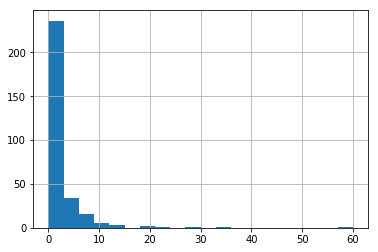

In [3]:
lead_hist = buffalo_lead['lead_ppb'].hist(bins = 20)

## Mapping

I did some basic map visualization that should be available shortly on my website (will edit with link). 
It is immediately clear how sparse the sampling is, and there are large areas on the map that have not been sampled at all.

In [4]:
import folium

import branca.colormap as cm

max_lead = buffalo_lead['lead_ppb'].max()
min_lead = buffalo_lead['lead_ppb'].min()



buffalo_coord = [42.8864, -78.8784]


map_buffalo = folium.Map(location=buffalo_coord, zoom_start=12,tiles='cartodbpositron', width = 640, height=480)

for index, row in buffalo_lead.iterrows():
    shade = 'blue'
    if row['lead_ppb'] > 2.0:
        shade = 'red'
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=1, color=shade, fill_color=shade).add_to(map_buffalo)

map_buffalo.add_child(folium.LatLngPopup())

map_buffalo

## Next step: merging in housing data

The next step of the preprocessing involved getting housing data. Unlike Flint, Buffalo publishes their municipal data [on an open portal](https://data.buffalony.gov/). So it was a relatively simple task to query the [2018-2019 Assessment Roll](https://data.buffalony.gov/Government/2018-2019-Assessment-Roll/kckn-jafw) and grab the features I needed (`home age` and `property value` for each residence)

The `retrieve_assessment_data` function searches for matches to the properties based on matching street name `Prop_Num_str` and matching street number `PropStreet`. 

### joblib caching

We are using a public API provided by the City of Buffalo. Each call is relatively time consuming and repeating calls would waste time and computing resources. We elected to use joblib to cache a list of server responses on disk. The ` @memory.cache` decorator will return the cached responses if they are available on disk, so we can re-run that cell without re-running the time intensive and compute intensive task.

In [5]:
cachedir = '.'
memory = Memory(cachedir, verbose=0)

@memory.cache
def retrieve_assessment_data(df):
    responses = []
    for index, row in df.iterrows():
        r = requests.get('https://data.buffalony.gov/resource/kckn-jafw.json', {'hsenofr': row['Prop_Num_str'], 'street':row['PropStreet'].upper()})
        json_resp = r.json()
        responses.append(json_resp)
        time.sleep(0.5)
    return responses


Here we run the function we defined above, pulling the data from the server or from the cache. Once we have the list, we iterate through and access the `totalval` home value and `yrbuilt` home age data we require for our model.

In [6]:
assessment_data = retrieve_assessment_data(buffalo_lead)

In [7]:
data = {}

for index, assessment in enumerate(assessment_data):
    try:
        data[index] = {'SEV' : assessment[0]['totalval'], 'yearBuilt' : assessment[0]['yrblt'],
                       'lat' : assessment[0]['latitude'], 'lon' : assessment[0]['longitude']}
    except:
        pass

This approach worked well enough at the beginning, but it's clear that in order to get the best possible results I will need to use the Google Maps API.

## Google Maps API



Now we can read the home values and home ages into dataframes, then join them into `age_value_df`.
That dataframe is joined into the `buffalo_lead` dataframe. Now we have all the necessary data for our model, so once we check the data and save it to disk we can move on and get started on the Flint data. 

In [8]:
assessment_data_df = pd.DataFrame.from_dict(data, orient='index')
#age_df = pd.DataFrame.from_dict(ages, orient='index')
#age_value_df = value_df.join(age_df, how='inner', rsuffix='_r')

#age_value_df.rename(columns={'0':'SEV', '0_r':'yearBuilt'}, inplace=True)

buffalo_lead = buffalo_lead.join(assessment_data_df)

In [9]:
buffalo_lead.head()

,the_geom,cartodb_id,year,lead_ppb,address,zipcode,latitude,longitude,Prop_Num_str,PropStreet,SEV,yearBuilt,lat,lon
0,0101000020E610000053E9279CDDB353C0003B376DC66F...,1,2002,0.0,"45 Kopernik Buffalo, NY, 14206",14206,42.873243,-78.810401,45,Kopernik,65700,1918,42.87324534512372,-78.81040071124237
1,0101000020E61000000ECAEA0CC2B853C09A362DC25E78...,2,2002,0.0,"95 Howell Buffalo, NY, 14207",14207,42.940392,-78.886844,95,Howell,42000,1900,42.940392051614374,-78.88677052043886
2,0101000020E6100000B5A1629CBFB853C033A083D3277A...,3,2002,0.0,"106 Rebecca Buffalo, NY, 14207",14207,42.954340,-78.886695,106,Rebecca,NaN,NaN,NaN,NaN
3,0101000020E610000016342DB132B653C09949D40B3E75...,4,2002,0.0,"141 Butler Buffalo, NY, 14208",14208,42.915956,-78.846844,141,Butler,41600,1910,42.915958181922164,-78.8468424392614
4,0101000020E610000017963FDF16B653C0D57B2AA73D75...,5,2002,0.0,"187 Butler Buffalo, NY, 14208",14208,42.915944,-78.845146,187,Butler,42600,1910,42.91594497617505,-78.84514253639803


In [10]:
buffalo_lead.count()

the_geom        300
cartodb_id      300
year            300
lead_ppb        300
address         300
zipcode         300
latitude        300
longitude       300
Prop_Num_str    300
PropStreet      300
SEV             252
yearBuilt       252
lat             252
lon             252
dtype: int64

This is concerning. Of the 300 samples in Buffalo, we've only been able to get a home value and home age for 252 of them. It's clear we'll need to use a more flexible approach to find and join the appropriate addresses. 

In [23]:
buffalo_lead_na = buffalo_lead[buffalo_lead.isna().any(axis=1)]

@memory.cache
def retrieve_assessment_data_select(df):
    responses = []
    for index, row in df.iterrows():
        querystr = 'select * search \'{} {}\''.format(row['Prop_Num_str'], row['PropStreet'])
        r = requests.get('https://data.buffalony.gov/resource/kckn-jafw.json', {'$query': querystr})
        json_resp = r.json()
        responses.append(json_resp)
        time.sleep(0.5)
    return responses


In [24]:
assessment_data_na = retrieve_assessment_data_select(buffalo_lead_na)

In [27]:
len(assessment_data_na)

47

In [28]:
data = {}

for index, assessment in zip(buffalo_lead_na.index.tolist(), assessment_data_na):
    try:
        data[index] = {'SEV' : assessment[0]['totalval'], 'yearBuilt' : assessment[0]['yrblt'],
                       'lat' : assessment[0]['latitude'], 'lon' : assessment[0]['longitude']}
    except:
        pass

data

{55: {'SEV': '180000',
  'yearBuilt': '1900',
  'lat': '42.906697352993056',
  'lon': '-78.88068516476628'},
 56: {'SEV': '110700',
  'yearBuilt': '1989',
  'lat': '42.95434503955554',
  'lon': '-78.88670342957053'},
 119: {'SEV': '39000',
  'yearBuilt': '1920',
  'lat': '42.93392758580618',
  'lon': '-78.81876050259842'},
 132: {'SEV': '40000',
  'yearBuilt': '1930',
  'lat': '42.9569937584034',
  'lon': '-78.88892842989691'},
 134: {'SEV': '120000',
  'yearBuilt': '1956',
  'lat': '42.95190998351449',
  'lon': '-78.84683084624264'},
 135: {'SEV': '110700',
  'yearBuilt': '1989',
  'lat': '42.95434503955554',
  'lon': '-78.88670342957053'},
 138: {'SEV': '31000',
  'yearBuilt': '1900',
  'lat': '42.92029595141097',
  'lon': '-78.89784595273088'},
 151: {'SEV': '40000',
  'yearBuilt': '1910',
  'lat': '42.9471908921915',
  'lon': '-78.87568900385706'},
 158: {'SEV': '175000',
  'yearBuilt': '1921',
  'lat': '42.94221097612849',
  'lon': '-78.84607666780728'},
 170: {'SEV': '110700',
  

In [29]:
assessment_na_df = pd.DataFrame.from_dict(data, orient='index')


In [30]:
buffalo_lead = buffalo_lead.fillna(assessment_na_df)

buffalo_lead.count()

the_geom        300
cartodb_id      300
year            300
lead_ppb        300
address         300
zipcode         300
latitude        300
longitude       300
Prop_Num_str    300
PropStreet      300
SEV             282
yearBuilt       282
lat             282
lon             282
dtype: int64

In [35]:
buffalo_lead.head()

,the_geom,cartodb_id,year,lead_ppb,address,zipcode,latitude,longitude,Prop_Num_str,PropStreet,SEV,yearBuilt,lat,lon
0,0101000020E610000053E9279CDDB353C0003B376DC66F...,1,2002,0.0,"45 Kopernik Buffalo, NY, 14206",14206,42.873243,-78.810401,45,Kopernik,65700,1918,42.87324534512372,-78.81040071124237
1,0101000020E61000000ECAEA0CC2B853C09A362DC25E78...,2,2002,0.0,"95 Howell Buffalo, NY, 14207",14207,42.940392,-78.886844,95,Howell,42000,1900,42.940392051614374,-78.88677052043886
2,0101000020E6100000B5A1629CBFB853C033A083D3277A...,3,2002,0.0,"106 Rebecca Buffalo, NY, 14207",14207,42.954340,-78.886695,106,Rebecca,110700,1989,42.95434503955554,-78.88670342957053
3,0101000020E610000016342DB132B653C09949D40B3E75...,4,2002,0.0,"141 Butler Buffalo, NY, 14208",14208,42.915956,-78.846844,141,Butler,41600,1910,42.915958181922164,-78.8468424392614
4,0101000020E610000017963FDF16B653C0D57B2AA73D75...,5,2002,0.0,"187 Butler Buffalo, NY, 14208",14208,42.915944,-78.845146,187,Butler,42600,1910,42.91594497617505,-78.84514253639803


Now we are closer, with 282 meaning we have only 18 left to go. I will do the final 18 by hand. 

Before we get to that, I would like to check that we have the correct addresses joined up by calculating the distance between the assessment data and the lead data. I'll be using the `geopy` library.

In [41]:
import geopy.distance


print(geopy.distance.distance(coords_1, coords_2).m)


def grab_distances(df):
    distances = []
    for index, row in df.iterrows():
        try:
            point1 = (row['latitude'], row['longitude'])
            point2 = (row['lat'], row['lon'])
            distances.append(geopy.distance.distance(point1, point2).m)
        except:
            pass
    return distances

lead_dist = grab_distances(buffalo_lead)
len([dist for dist in lead_dist if dist > 20.0])

279352.90160430095


25

In [15]:
with open('data/buffalo_lead_preprocessed.csv', 'w+') as f:
    buffalo_lead.to_csv(f)

In [16]:
buffalo_lead_na = buffalo_lead[buffalo_lead.isna().any(axis=1)]
buffalo_lead_na.shape

(47, 14)

In [17]:
r = requests.get('https://data.buffalony.gov/resource/kckn-jafw.json', {'latitude': row['Prop_Num_str'], 'street':row['PropStreet'].upper()})